In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import datetime

In [2]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [126]:
def prop_counts(ser: pd.Series):
    vc = ser.value_counts()
    res = vc / vc.sum()
    return (res * 1000).apply(lambda x: str(int(x) / 10) + "%")

<IPython.core.display.Javascript object>

In [3]:
secop = catalog.load("secop_2_cont_clean")

                    INFO     Loading data from 'secop_2_cont_clean' (ParquetDataSet)...         ]8;id=338648;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=12221;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

In [4]:
features_text = 100
features_tfid = [f"feat_text_{i+1}" for i in range(features_text)]
vectorizer = TfidfVectorizer(max_features=features_text)
text_df = pd.DataFrame(
    columns=features_tfid,
    data=np.array(
        vectorizer.fit_transform(secop["full_contract_description"]).todense()
    ),
)


<IPython.core.display.Javascript object>

In [5]:
secop = pd.merge(secop, text_df, how="inner", left_index=True, right_index=True)

<IPython.core.display.Javascript object>

In [6]:
secop = pd.get_dummies(
    secop, columns=["orden", "modalidad_de_contratacion"], drop_first=True
)

<IPython.core.display.Javascript object>

In [27]:
secop["date_duration"] = secop.apply(
    lambda row: (row["fecha_de_inicio_del_contrato"], row["fecha_de_fin_del_contrato"]),
    axis=1,
)

<IPython.core.display.Javascript object>

In [7]:
secop_personas = secop[secop["tipodocproveedor"] == "cedula de ciudadania"].copy()

<IPython.core.display.Javascript object>

In [8]:
secop_empresas = secop[secop["tipodocproveedor"] == "nit"].copy()

<IPython.core.display.Javascript object>

In [9]:
del text_df  # secop,

<IPython.core.display.Javascript object>

In [10]:
secop_personas.columns[:30]

Index(['index', 'nombre_entidad', 'departamento', 'ciudad',
       'proceso_de_compra', 'referencia_del_contrato', 'estado_contrato',
       'descripcion_del_proceso', 'fecha_de_firma',
       'fecha_de_inicio_del_contrato', 'fecha_de_fin_del_contrato',
       'tipodocproveedor', 'documento_proveedor', 'proveedor_adjudicado',
       'valor_del_contrato', 'objeto_del_contrato', 'dias_adicionados',
       'nit_entidad', 'log_valor_del_contrato', 'full_contract_description',
       'duration_days', 'Agricultura', 'Hidrocarburos', 'Manufactura',
       'ServiciosPublicos', 'Construccion', 'Comercio', 'Comunicaciones',
       'Financiero', 'Inmobiliaria'],
      dtype='object')

<IPython.core.display.Javascript object>

In [11]:
cols_pca = (
    ["Poblacion", "ValorAgregado", "Impuestos", "PIB"]
    + features_tfid
    + [
        c
        for c in secop_personas.columns
        if "orden" in c or "modalidad_de_contratacion" in c
    ]
)

<IPython.core.display.Javascript object>

In [12]:
ss = StandardScaler()

<IPython.core.display.Javascript object>

In [13]:
n_pca = 10
pca = PCA(n_components=n_pca)
data_pca = pca.fit_transform(ss.fit_transform(secop_personas[cols_pca]))

<IPython.core.display.Javascript object>

In [14]:
secop_personas.drop(cols_pca, axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [15]:
secop_personas[[f"pca_{i}" for i in range(n_pca)]] = data_pca

<IPython.core.display.Javascript object>

In [76]:
def max_open_contracts(ser):
    if len(ser) == 1:
        return 1
    dates_to_ck = list(ser.apply(lambda x: x[0])) + list(
        ser.apply(lambda x: x[1] + datetime.timedelta(days=1))
    )
    return max(
        [
            ((ser.apply(lambda x: x[0]) <= d) & (ser.apply(lambda x: x[1]) >= d)).sum()
            for d in dates_to_ck
        ]
    )

<IPython.core.display.Javascript object>

In [77]:
today = datetime.date.today()


def tot_time_open_contracts(ser):
    return len(
        set(
            np.concatenate(
                ser.apply(lambda x: list(pd.date_range(x[0], min(x[1], today))))
            )
        )
    )

<IPython.core.display.Javascript object>

In [78]:
df_personas = secop_personas.groupby("documento_proveedor").agg(
    {
        **{
            "nombre_entidad": pd.Series.nunique,
            "index": "count",
            "ciudad": pd.Series.nunique,
            "valor_del_contrato": "mean",
            "dias_adicionados": "mean",
            "date_duration": [max_open_contracts],  # , tot_time_open_contracts],
            "fecha_de_inicio_del_contrato": "min",
        },
        **{f"pca_{i}": "mean" for i in range(n_pca)},
    }
)
df_personas.columns = ["_".join(x) for x in df_personas.columns.to_flat_index()]

<IPython.core.display.Javascript object>

In [81]:
df_personas["prop_ent"] = 1 / df_personas["nombre_entidad_nunique"]
df_personas["prop_ciudad"] = 1 / df_personas["nombre_entidad_nunique"]
df_personas["log_valor_del_contrato_mean"] = df_personas[
    "valor_del_contrato_mean"
].apply(np.log)

<IPython.core.display.Javascript object>

In [85]:
df_personas["days_since_first_contract"] = (
    today - df_personas["fecha_de_inicio_del_contrato_min"]
).apply(lambda x: x.days)

<IPython.core.display.Javascript object>

In [89]:
df_personas["days_since_first_by_count"] = df_personas["days_since_first_contract"]/df_personas["index_count"]


<IPython.core.display.Javascript object>

In [91]:
df_personas.drop(
    [
        "nombre_entidad_nunique",
        "ciudad_nunique",
        "valor_del_contrato_mean",
        "fecha_de_inicio_del_contrato_min",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

In [144]:
df_personas["cluster"] = DBSCAN(eps=2, min_samples=5).fit_predict(
    ss.fit_transform(
        df_personas.drop(
            ["cluster", "documento_proveedor", "proveedor_adjudicado"], axis=1
        ).values
    )
)

<IPython.core.display.Javascript object>

In [102]:
df_personas["cluster"] = DBSCAN(eps=2, min_samples=5).fit_predict(
    ss.fit_transform(df_personas.drop('documento_proveedor',axis=1).values)
)

<IPython.core.display.Javascript object>

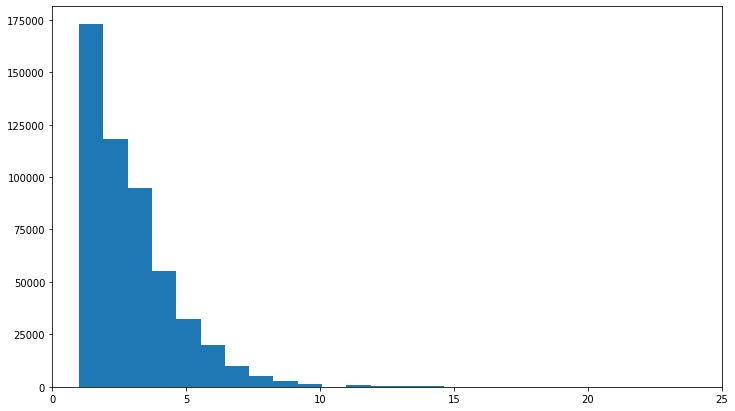

<IPython.core.display.Javascript object>

In [117]:
fig, ax = plt.subplots()
ax.hist(df_personas["index_count"], bins=240)
ax.set_xlim(0, 25)
fig.set_size_inches(12, 7)

In [127]:
prop_counts(df_personas["date_duration_max_open_contracts"]).head(5)  # .value_counts()

1    88.7%
2     9.9%
3     0.9%
4     0.1%
5     0.0%
Name: date_duration_max_open_contracts, dtype: object

<IPython.core.display.Javascript object>

In [136]:
df_personas = pd.merge(
    df_personas,
    secop[["proveedor_adjudicado", "documento_proveedor"]].drop_duplicates(subset='documento_proveedor'),
    how="left",
    on="documento_proveedor",
)

<IPython.core.display.Javascript object>

In [145]:
pca = PCA(n_components=2)
df_personas[["x_pca", "y_pca"]] = pca.fit_transform(
    df_personas.drop(
        ["cluster", "documento_proveedor", "proveedor_adjudicado"], axis=1
    ).values
)

<IPython.core.display.Javascript object>

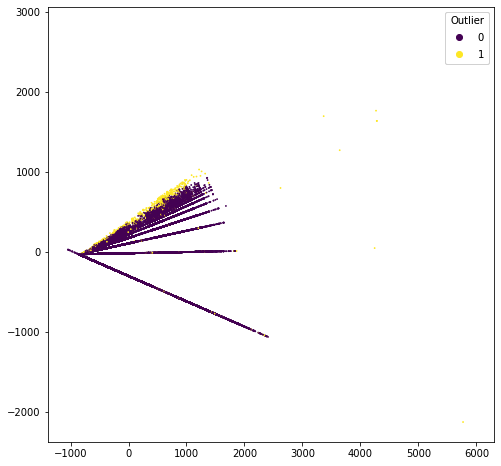

<IPython.core.display.Javascript object>

In [151]:
fig, ax = plt.subplots()
scat = ax.scatter(
    df_personas["x_pca"], df_personas["y_pca"], c=df_personas["cluster"] == -1, s=0.6
)
legend = ax.legend(*scat.legend_elements(), loc="upper right", title="Outlier")
ax.add_artist(legend)
fig.set_size_inches(8, 8)

In [153]:
catalog.save(
    "df_clusters_contractors",
    df_personas[
        [
            "documento_proveedor",
            "proveedor_adjudicado",
            "index_count",
            "date_duration_max_open_contracts",
            "log_valor_del_contrato_mean",
            "cluster",
            "x_pca",
            "y_pca",
        ]
    ],
)

[08/15/22 01:33:51] INFO     Saving data to 'df_clusters_contractors' (ParquetDataSet)...       ]8;id=938305;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=674438;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

<IPython.core.display.Javascript object>

In [141]:
df_personas[df_personas["cluster"] == -1].sort_values(
    "index_count", ascending=False
).head(20)

,documento_proveedor,index_count,dias_adicionados_mean,date_duration_max_open_contracts,pca_0_mean,pca_1_mean,pca_2_mean,pca_3_mean,pca_4_mean,pca_5_mean,...,pca_7_mean,pca_8_mean,pca_9_mean,prop_ent,prop_ciudad,log_valor_del_contrato_mean,days_since_first_contract,days_since_first_by_count,cluster,proveedor_adjudicado
267696,98475036,219,0.821918,43,-0.046546,-0.423400,1.673372,0.161327,0.023734,-1.772883,...,6.599925,0.088057,1.518557,0.009009,0.009009,17.431565,1713,7.821918,-1,dota hogar colchones
177252,59706955,204,3.313725,38,0.267381,-1.404240,2.530553,-0.176100,1.314510,-1.869544,...,5.805570,-0.511711,1.126793,0.017857,0.017857,18.600418,1410,6.911765,-1,deicy bravo jojoa
63581,23622025,172,0.715116,18,-0.493721,0.263277,1.794113,0.904088,-0.357872,-1.232693,...,6.812876,0.334897,1.568188,0.017857,0.017857,14.769836,1564,9.093023,-1,maria araceli leiva perilla
47807,17068260,169,19.751479,48,6.367724,0.845085,0.556430,-0.773149,0.024033,-0.980142,...,1.859662,1.404825,-0.619994,0.125000,0.125000,19.844395,1593,9.426036,-1,rafael antonio salamanca
249287,86075963,163,0.797546,14,0.025769,-0.927657,0.452002,-0.899477,0.531622,-1.859707,...,7.686668,-0.189100,1.969521,0.142857,0.142857,15.965232,1662,10.196319,-1,carlos ernesto rey aguilera
237219,80222117,148,3.918919,30,0.534181,-0.481944,0.695768,-0.472104,-0.304566,-1.419020,...,4.515492,0.870081,0.933605,0.008696,0.008696,18.409268,1718,11.608108,-1,miguel angel vallejo burgos
453904,1102720365,147,4.414966,12,0.244779,-0.500521,1.122730,0.347915,-0.206281,-1.408963,...,5.840912,0.292502,1.505907,0.009615,0.009615,16.925518,2330,15.850340,-1,mosthye vicente medina rodriguez - world m&d ...
302261,1016018644,129,4.426357,22,0.366106,-0.754169,1.025366,-0.297631,-1.031642,-2.586797,...,6.631485,0.512133,1.906689,0.014925,0.014925,16.281054,1624,12.589147,-1,bioemedic ingenieria biomedica
255383,91282210,127,3.165354,37,-1.366431,1.697657,3.907712,3.536135,-1.122033,-0.306703,...,7.284369,1.722037,2.257033,0.027027,0.027027,18.039303,1784,14.047244,-1,jairo osorio caballero
270827,830004892,122,9.508197,25,2.950823,-0.162726,0.430119,-0.652987,-0.344847,-1.182113,...,3.341962,0.820963,0.444149,0.043478,0.043478,19.483858,1712,14.032787,-1,tecnica electromedica s.a.


<IPython.core.display.Javascript object>

In [103]:
df_personas["cluster"].value_counts()

0      405957
2       40308
3       34578
4       14384
1        6593
        ...  
325         4
94          4
261         4
211         4
18          3
Name: cluster, Length: 414, dtype: int64

<IPython.core.display.Javascript object>

In [101]:
df_personas["cluster"].value_counts()

0       225012
-1       137144
 27       13634
 4         9782
 16        8473
          ...  
 6416         2
 4665         2
 7099         1
 6025         1
 4727         1
Name: cluster, Length: 7715, dtype: int64

<IPython.core.display.Javascript object>

In [99]:
df_personas["cluster"].value_counts()

-1        390863
 31         1379
 2           996
 69          704
 301         474
           ...  
 8380          3
 10899         3
 11069         2
 8978          2
 11062         2
Name: cluster, Length: 11158, dtype: int64

<IPython.core.display.Javascript object>

In [26]:
secop[secop["documento_proveedor"] == df_personas.sort_values("index_count").index[-3]][
    "modalidad_de_contratacion_menor cuantia"
].mean()

1.0

<IPython.core.display.Javascript object>

In [ ]:
[
    [
        "proveedor_adjudicado",
        "descripcion_del_proceso",
        "nombre_entidad",
        "modalidad_de_contratacion_contratacion directa",
    ]
]

In [33]:
df_personas.head(20)

,index_count,ciudad_count,ciudad_nunique,valor_del_contrato_sum
documento_proveedor,,,,
1004475,3,3,1,100896483
1004480,2,2,1,29557500
1004546,1,1,1,14449982
1007616,2,2,1,65000000
1009523,6,6,1,75125600
1009549,5,5,1,77495391
1009561,6,6,2,23680000
1011527,1,1,1,6450788
1013280,1,1,1,14100000


<IPython.core.display.Javascript object>

In [23]:
df_personas["ciudad"]

,count
documento_proveedor,
1004475,3
1004480,2
1004546,1
1007616,2
1009523,6
...,...
1335280909,3
1335281534,5
1707605448,2


<IPython.core.display.Javascript object>

In [8]:
secop["tipodocproveedor"]

0          cedula de ciudadania
1          cedula de ciudadania
2          cedula de ciudadania
3          cedula de ciudadania
4          cedula de ciudadania
                   ...         
1654284    cedula de ciudadania
1654285    cedula de ciudadania
1654286                     nit
1654287    cedula de ciudadania
1654288    cedula de ciudadania
Name: tipodocproveedor, Length: 1654289, dtype: object

<IPython.core.display.Javascript object>